In [1]:
import numpy as np
import matplotlib.pyplot as plt
from elf.io import open_file
import z5py
from pathlib import Path

import os
import imageio
import mobie
import mobie.metadata as metadata

In [2]:
def print_key_tree(f: z5py.File):
    
    print(f"Key structure of z5 file {f.filename}")
    f.visititems(lambda name, obj: print(name))


def read_volume(f: z5py.File, key: str, roi: np.lib.index_tricks.IndexExpression = np.s_[:]):
    try:
        ds = f[key]
    except KeyError:
        print(f"No key {key} in file {f.filename}")
        print_key_tree(f)
        return None
        
    ds.n_threads = 8
    print(f"Reading roi {roi} of volume {key} from {f.filename}")
    vol = ds[roi]
    print(f"Read volume with shape {vol.shape}, data type {vol.dtype}")
    
    return vol


In [3]:
scratch_dir = Path("/scratch/buglakova/data/cryofib/registration_fluo/F107_A2_3dclem")
fluo_dir = scratch_dir / "fluo"
em_dir = scratch_dir / "em"
segm_em_nuclei_dir = scratch_dir / "segm_em_nuclei"

In [70]:
with open_file(str(fluo_dir)) as f:
    ims = f["*.tiff"]
    print(ims.shape)

(55, 3343, 1482)


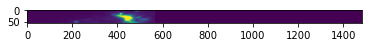

In [71]:
plt.imshow(ims[:, 100, :])

In [86]:
from typing import Tuple, Dict


def create_ind(arr: np.array):
    stop = arr.shape
    start = [0] * len(stop)
    step = [1] * len(stop)
    return start, stop, step


def read_ind(start: Tuple, stop: Tuple, step: Tuple) -> np.lib.index_tricks.IndexExpression:
    ind_exp = tuple(slice(*slice_param) for slice_param in zip(start, stop, step))
    return ind_exp


def write_ind(ind_exp: np.lib.index_tricks.IndexExpression):
    start = tuple(sl.start for sl in ind_exp)
    stop = tuple(sl.stop for sl in ind_exp)
    step = tuple(sl.step for sl in ind_exp)
    return start, stop, step


def tif2n5(tif_dir: Path,
            n5_path: Path,
            n5_key: str,
            reg_exp: str = "*.tiff",
            description: str = "",
            order: str = "zyx",
            unit: str = "nm",
            resolution: Tuple = (1, 1, 1),
            roi: Dict = None):

    f_out = z5py.File(n5_path, "w")
    with open_file(str(tif_dir)) as f:
        print(f"Reading tif files from {tif_dir}")
        tiff_stack_obj = f[reg_exp]
        imgs = tiff_stack_obj[:]
        print(f"Read {tiff_stack_obj.shape} of type {tiff_stack_obj.dtype}")

        chunks = (1, 512, 512)
        shape = imgs.shape
        compression = "gzip"
        dtype = imgs.dtype

        ds = f_out.create_dataset(n5_key, shape=shape, compression=compression,
                            chunks=chunks, dtype=dtype, n_threads=8)
        print(f"Writing to {n5_path}, key {n5_key}")
        ds[:] = imgs

        # Attributes required for future registration
        print(f"Assigning attributes of the dataset")
        attributes = ds.attrs
        attributes["description"] = description
        attributes["unit"] = unit
        if roi is None:
            start, stop, step = create_ind(imgs)
            roi = {"start": start, "stop": stop, "step": step}
        attributes['roi'] = roi
        attributes['resolution'] = resolution

In [87]:
tif2n5(tif_dir=fluo_dir,
        n5_path=fluo_dir / "fluo.n5",
        n5_key="raw",
        reg_exp="*.tiff",
        description="Raw fluorescence data",
        order="zyx",
        unit="nm",
        resolution=(1849.5, 221.4, 221.4),
        roi=None)

Reading tif files from /scratch/buglakova/data/cryofib/registration_fluo/F107_A2_3dclem/fluo
Read (55, 3343, 1482) of type uint8
Writing to /scratch/buglakova/data/cryofib/registration_fluo/F107_A2_3dclem/fluo/fluo.n5, key raw
Assigning attributes of the dataset
{'start': [0, 0, 0], 'stop': (55, 3343, 1482), 'step': [1, 1, 1]}


In [4]:
# the location of the mobie project that will be created
# we recommend that the mobie project folders have the structure <PROECJT_ROOT_FOLDER/data>
# the folder 'data' will contain the sub-folders for individual datasets
mobie_project_folder = "/scratch/buglakova/data/cryofib/registration_fluo/mobie_projects/fibsem-registration/data"

# name of the dataset that will be created.
# one project can contain multiple datasets
dataset_name = "fluo-ds"
dataset_folder = os.path.join(mobie_project_folder, dataset_name)

# the platform and number of jobs used for computation.
# choose 'local' to run computations on your machine.
# for large data, it is also possible to run computation on a cluster;
# for this purpose 'slurm' (for slurm cluster) and 'lsf' (for lsf cluster) are currently supported
target = "local"
max_jobs = 4

In [8]:
# The 'default' image for our example dataset is a 2d EM slice showing an overview of the dataset.
input_file = str(fluo_dir / "fluo.n5")
input_key = "raw"
# This is the name that will be given to the image source in mobie.
raw_name = "fluo"
# The name of the menu from which the image can be added to the viewer.
# Here, we choose "em", because this is an EM image slice.
menu_name = "fluo"

# We need some metadata to create the n5-file in big-data-viewer format:
# - unit: the phyiscal unit of the coordinate system
# - resolution: the size of one voxel in the physical unit, this needs to be a tuple/list of length 3,
#               specifying the size for each of the 3 spatial dimensions
# - chunks: the size of the chunks (in voxels) that are used to store the output file.
#           good choices are usually (1, 512, 512) for 2d data and (64, 64, 64) for 3d data
# - scale_factors: the scale factors used for downsampling the input when creating the image pyramid
#                  this needs to be a list, where each entry specifies the scale factors for the 3 axes.
# Note that axes are always listed in the order ZYX here (in the java implementation of mobie / big-data-viewer the axis convention is XYZ).
# Also note that the values for all three axes (ZYX) need to be specified. In the case of 2d data, the value
# for Z should be set to 1.

f_out = z5py.File(input_file, "r")
ds = f_out[input_key]


In [11]:
f_out['raw']

In [9]:
ds.attrs["resolution"]

[1849.5, 221.4, 221.4]

In [12]:
unit = ds.attrs["unit"]
resolution = ds.attrs["resolution"]
chunks = (1, 512, 512)
scale_factors = 4 * [[1, 2, 2]]

mobie.add_image(
    input_path=input_file, 
    input_key=input_key,  # the input is a single tif image, so we leave input_key blank
    root=mobie_project_folder,
    dataset_name=dataset_name,
    image_name=raw_name,
    menu_name=menu_name,
    resolution=resolution,
    chunks=chunks,
    scale_factors=scale_factors,
    is_default_dataset=True,  # mark this dataset as the default dataset that will be loaded by mobie
    target=target,
    max_jobs=max_jobs,
    unit=unit
)

/home/buglakov/miniconda3/envs/mobie/lib/python3.10/site-packages/luigi/parameter.py:279: UserWarning: Parameter "dtype" with value "None" is not of type string.
  warnings.warn('Parameter "{}" with value "{}" is not of type string.'.format(param_name, param_value))
DEBUG: Checking if DownscalingWorkflow(tmp_folder=tmp_fluo-ds_fluo, max_jobs=4, config_dir=tmp_fluo-ds_fluo/configs, target=local, dependency=DummyTask, input_path=/scratch/buglakova/data/cryofib/registration_fluo/F107_A2_3dclem/fluo/fluo.n5, input_key=raw, scale_factors=[[1, 2, 2], [1, 2, 2], [1, 2, 2], [1, 2, 2]], halos=[[1, 2, 2], [1, 2, 2], [1, 2, 2], [1, 2, 2]], dtype=None, int_to_uint=False, metadata_format=bdv.n5, metadata_dict={"resolution": [1849.5, 221.4, 221.4], "unit": "nm", "setup_name": "fluo"}, output_path=/scratch/buglakova/data/cryofib/registration_fluo/mobie_projects/fibsem-registration/data/fluo-ds/images/bdv-n5/fluo.n5, output_key_prefix=, force_copy=False, skip_existing_levels=False, scale_offset=0) is 